# uSEIR model KFit

### checks
### test that a KF follows the epidemic


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 12

In [2]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Fri May 22 11:25:21 2020


In [3]:
import numpy as np
import pandas as pd
import matplotlib

In [4]:
fontsize=14
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }
plt.rcParams["font.size"     ] = fontsize

def figure(size = (10, 8)):
    plt.figure(figsize = size)

In [5]:
import c19.basic_models as cbm

from c19.types import SIR, SIR2

from scipy.integrate import odeint
#import scipy.integrate as spi
#from scipy.interpolate import interp1d

In [6]:
import c19.useir            as us
import c19.kfmysir          as kf

import scipy          as sp
import scipy.stats    as stats
import scipy.optimize as optimize

from numpy.linalg import inv
mprod_ = np.matmul
npa    = np.array

## uSEIR

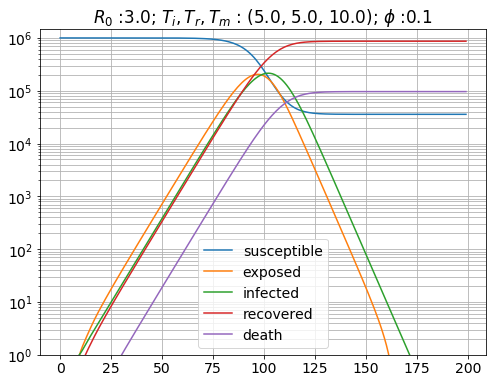

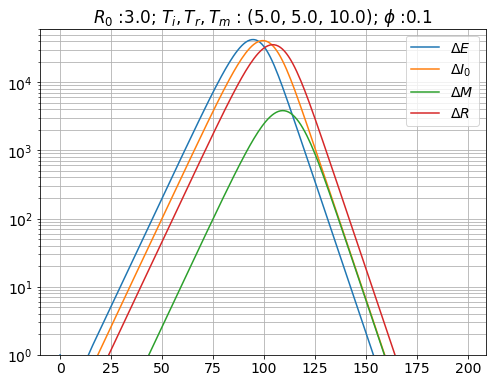

In [7]:
N               = 1e6
R0, TI, TR, TM  = 3., 5., 5., 10.
PhiM            = 0.1
ndays           = 200
rho             = 'poisson'
frho            = us.frho(rho)
ts = np.arange(ndays)
SS, DD          = us.uSEIR(N, R0, TI, TR, TM, PhiM, ndays, rho = rho)
S, E, I, R, M   = SS
DE, DI0, DR, DM = DD

title = r'$R_0$ :'+ str(R0)+ r'; $T_i, T_r, T_m$ : '+str((TI, TR, TM)) + r'; $\phi$ :'+str(PhiM)
us.plt_uSEIR(ts, SS, DD, title)

### Generate randon data

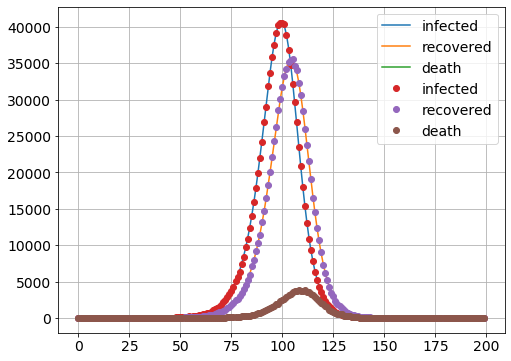

In [8]:
DS = DI0, DR, DM
ds = us.useir_rvdata(DI0, DR, DM)
us.plt_useir_rvdata(ts, DS, ds);

### Some extra checks

$$
\Delta E(t) = - \Delta S() \\
\Delta I_0(t) =  \Delta \tilde{I}(t) = \beta(t) \; \Delta E(t) \circ \rho(t - t'| t_i) \\
\beta(t)      = (R_0/T_R) \, S(t)/N  \\
\Delta I_0(t) / \Delta \tilde{I}(t) \sim \beta(t + T_R)
$$

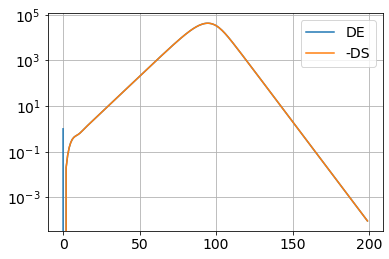

In [9]:
# test DE is -DS

des    = -us.mdeltas(S); des[0] = 0.
#des   = (R0/TR) * (1 - S/N) * I
plt.plot(ts,  DE , label = 'DE' )
plt.plot(ts,  des, label = '-DS')
plt.legend(); plt.grid(); plt.yscale('log')
#rhoi = us.fpois(TI)
#Is = [us.uV(FI[:i+1], ts[:i+1], rhoi) for i in range(len(ts))]

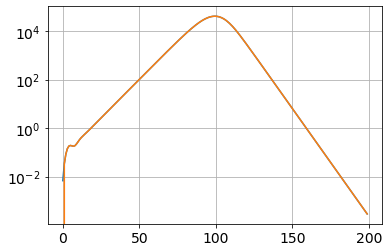

In [10]:
# test DI0 = DE (x) rhoI
rhoi   = frho(TI)
xdios  = npa([us.uV(DE[:i+1], ts[:i+1], rhoi) for i in range(len(ts))])

yscale = 'log'
plt.plot(ts, xdios)
plt.plot(ts, DI0); plt.yscale(yscale); plt.grid();

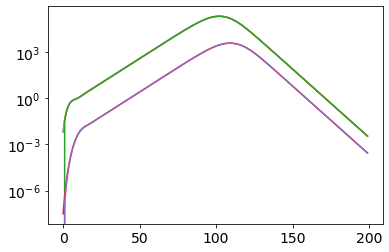

In [11]:
# test I is ninfecting
#nis, drs = us.ninfecting(ts, xdios, frho(TR))

rhor = frho(TR)
rhom = frho(TM)

def myrho(t):
    return (1 - PhiM) * rhor(t) + PhiM * rhom(t)

xnis, xxds = us.ninfecting(ts, xdios, myrho)

nis, xds = us.nis_(ts, xdios, frho(TR), frho(TM), PhiM)

yscale = 'log'
plt.plot(ts, nis);
plt.plot(ts, xnis);
plt.plot(ts, I); plt.yscale(yscale);
plt.plot(ts, xds[2]);
plt.plot(ts, DM);

### Estimation of r(t)

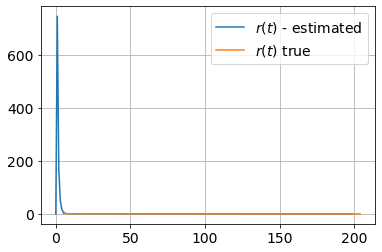

In [12]:
rhor = frho(TR)
rhom = frho(TM)

def myrho(t):
    return (1 - PhiM) * rhor(t) + PhiM * rhom(t)

betas = us.betas(ts, xdios, myrho, rhoi)

plt.plot(ts, betas, label = r'$r(t)$ - estimated');
plt.plot(TR + ts, (R0/TR) * S/N, label = r'$r(t)$ true ');
plt.grid(); plt.legend();

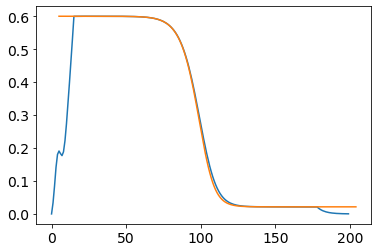

In [13]:
# test betas is dios / nes (E (x) rhoI) 

nes   = npa([us.uV(nis[0:i], ts[0:i], rhoi) for i in range(len(ts))])
betas = xdios/np.maximum(1., nes)
betas[nes <= 0.] = 0.
plt.plot(ts, betas);
plt.plot(TR + ts, (R0/TR) * S/N);

0.6


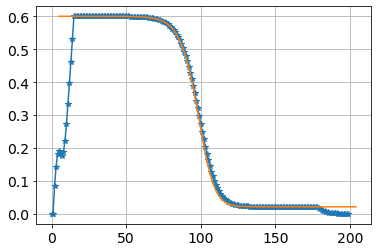

In [14]:
xdios  = npa([us.uV(I[:i], ts[:i], rhoi) for i in range(len(ts))])
betas = DI0/np.maximum(xdios, 1.)
betas[xdios <= 0] = 0.
plt.plot(ts, betas, marker = '*')
plt.plot(TR + ts, (R0/TR) * S/N)
plt.grid(); #plt.yscale('log');
print(R0/TR)

## KF test

### Generate randon data

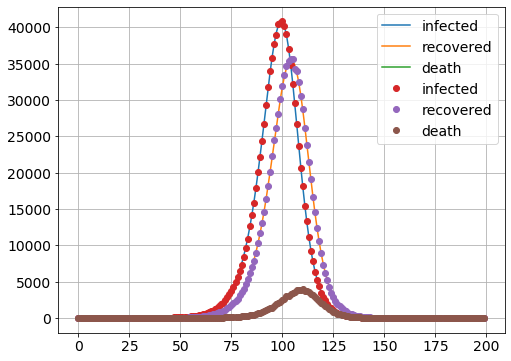

In [15]:
ds = us.useir_rvdata(DI0, DR, DM)
dios, drs, dms = ds
us.plt_useir_rvdata(ts, DS, ds);

### KF

$$
\Delta I (t) = r (t)\; I(t') \circ \rho_i(t-t'| t'_i)   \\
\Delta R (t) = \phi_r \; \Delta I(t') \circ \rho_r(t-t' | t_r) \\
\Delta M (t) = \phi_m \; \Delta I(t') \circ \rho_m(t-t' | t_m) \\
$$

The state 
$$
(r(t), \phi_r, \phi_m)
$$
The measurement
$$
(\Delta i, \Delta r, \Delta m)
$$

The $H$-matrix


$$
H_{i} = \begin{pmatrix} I(t') \circ \rho_i(t-t'| t'_i)  & 0  &   0 \\
0  &  \Delta I(t') \circ \rho_r(t - t' | t_r)  &   0 \\
0  &  0 &  \Delta I(t') \circ \rho_m(t-t' | t_m)
\end{pmatrix}
$$






### Measurements

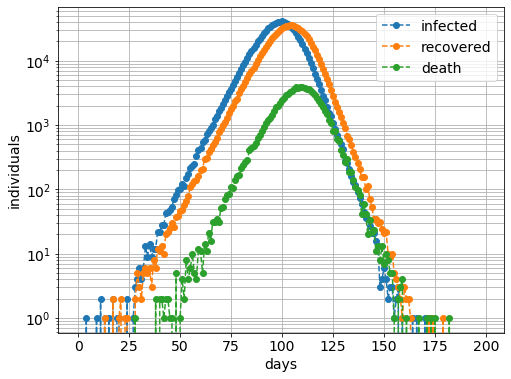

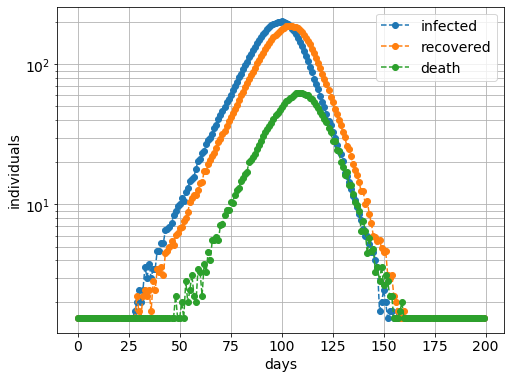

In [16]:
ms, ums      = us.meas(dios, drs, dms)
us.plt_meas(ts, ms, ums)

### check infeccious distribution

$$
\beta(t) = (R_0/T_R) S(t) / N
$$

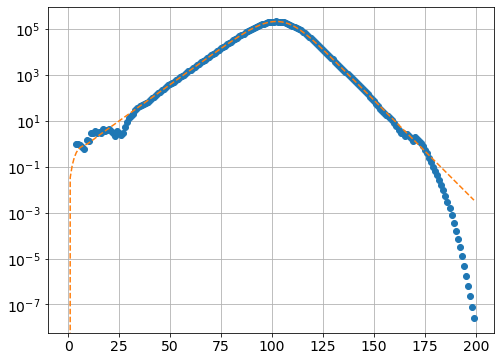

In [17]:
nis, _  = us.nis_(ts, dios, frho(TR), frho(TM), PhiM)
plt.figure(figsize = (8, 6))
plt.plot(ts, nis, marker = 'o', ls = '');
plt.plot(ts, I, ls = '--');
plt.grid(); plt.yscale('log');

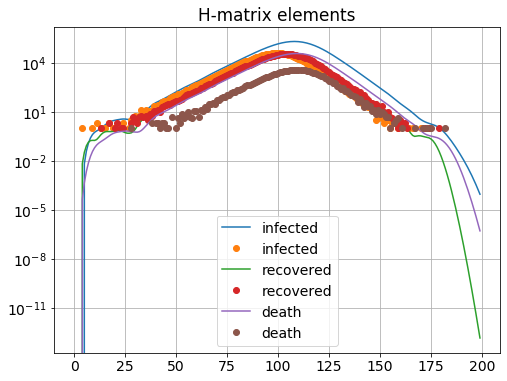

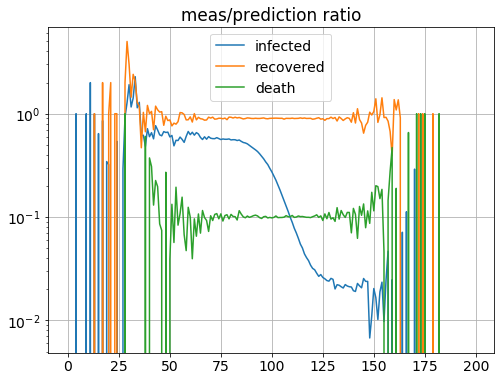

In [18]:
hs   = us.hmatrices(ts, dios, nis, frho(TI), frho(TR), frho(TM))
us.plt_hmatrices2(ts, hs, ms);

### run KF and plot results

[0.59664395 0.86262232 0.03641659] [ 0.28048027  0.77185247 -0.02142707] [ 0.02099539  0.69519055 -0.04316017]


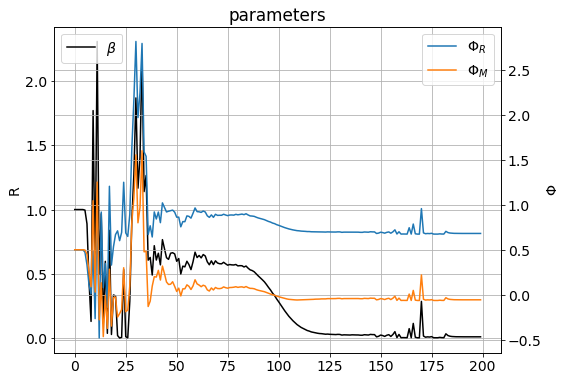

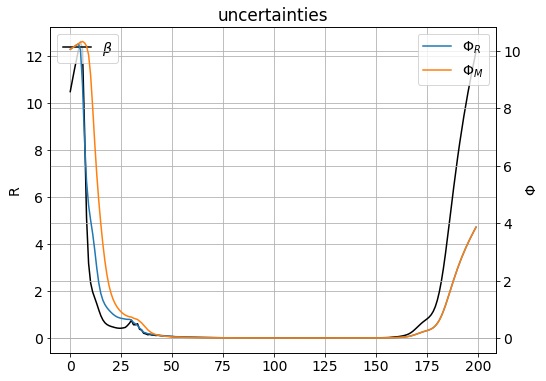

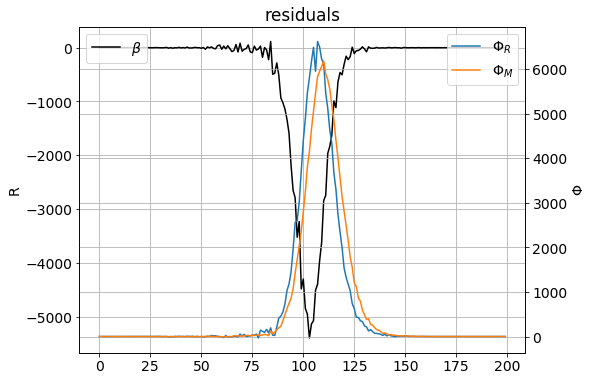

In [20]:
ms, ums      = us.meas(dios, drs, dms)
x0           = npa((1., 0.5, 0.5))
ux0          = np.identity(3) * 100
qs           = [npa((10., 1, 1)) for i in range(len(ms))]
xs, uxs, res = us.useir_kf(ms, ums, hs, x0, ux0, qs)
us.plt_useir_kf(ts, xs, uxs, res)
print(xs[50], xs[100], xs[150])

### Check r(t) from KF

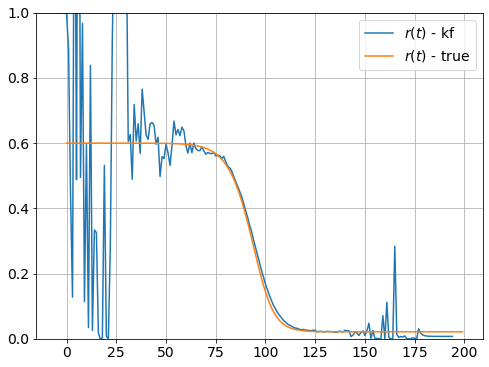

In [21]:
rs = [xi[0] for xi in xs]
plt.figure(figsize = (8, 6))
plt.plot(ts - TI, rs,  label = r'$r(t)$ - kf');
plt.plot(ts, (R0/TR) * S/N, label = r'$r(t)$ - true');
plt.grid(); plt.legend(); plt.ylim(0., 1.);

### Check Use proxy: death as new-infected

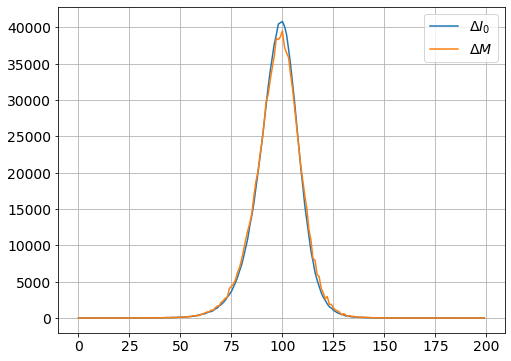

In [22]:
xdios        = np.zeros(len(dios))
i0 = int(TM)
xdios[:-i0]   = dms[i0:]/(PhiM)
#xdios           = dios/2.
plt.figure(figsize = (8, 6))
plt.plot(ts, dios , label = r'$\Delta I_0$')
plt.plot(ts, xdios, label = r'$\Delta M$');
plt.grid(); plt.legend(); #plt.yscale('log');

[0.64943453 0.82876944 0.01070912] [ 0.26555116  0.75250985 -0.03851027] [ 3.21192245e-06  6.66707591e-01 -6.94577049e-02]


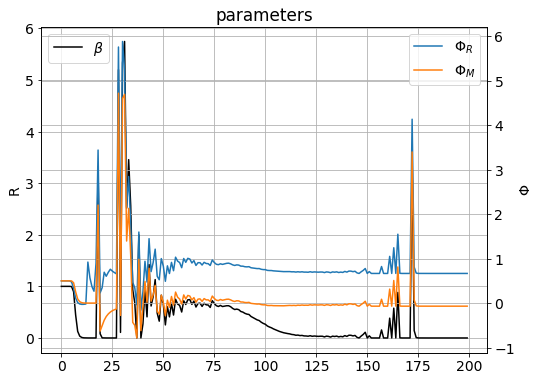

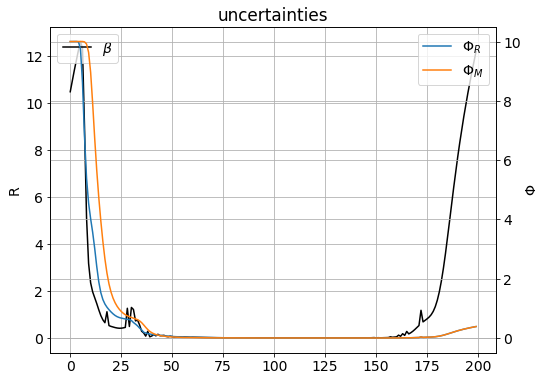

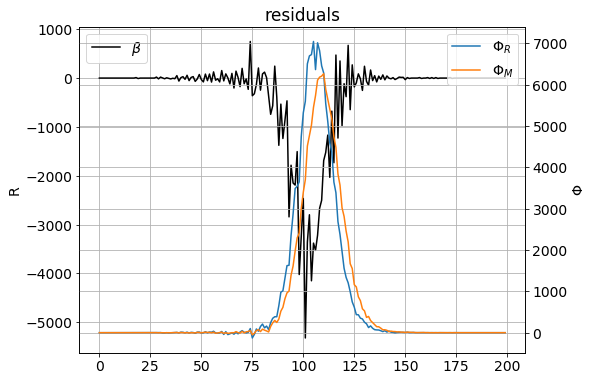

In [24]:
ms, ums      = us.meas(xdios, drs, dms)
x0           = npa((1., 0.5, 0.5))
ux0          = np.identity(3) * 100
qs           = [npa((10., 0.01, 0.01)) for i in range(len(ms))]
xs, uxs, res = us.useir_kf(ms, ums, hs, x0, ux0, qs)
us.plt_useir_kf(ts, xs, uxs, res)
print(xs[50], xs[100], xs[150])

### Check r(t)

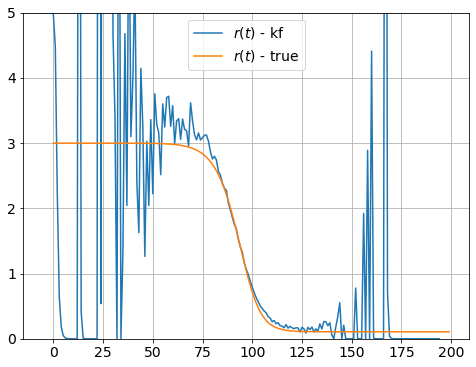

In [25]:
rs = npa([xi[0] for xi in xs])
plt.figure(figsize = (8, 6))
plt.plot(ts - TI, TR * rs, label = r'$r(t)$ - kf');
plt.plot(ts, TR* (R0/TR) * S/N, label = r'$r(t)$ - true');
plt.grid(); plt.legend(); plt.ylim(0., 5.);

### Check to scale proxy new-Infected distribution

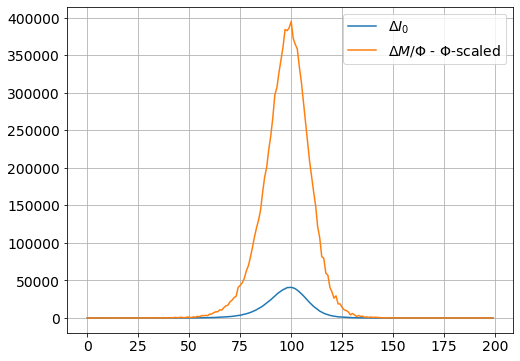

In [26]:
kfactor      = 10
xdios        = np.zeros(len(dios))
i0 = int(TM)
xdios[:-i0]  = kfactor * dms[i0:]/(PhiM)
#xdios           = dios/2.
plt.figure(figsize = (8, 6))
plt.plot(ts, dios , label = r'$\Delta I_0$')
plt.plot(ts, xdios, label = r'$\Delta M/\Phi$ - $\Phi$-scaled');
plt.grid(); plt.legend(); #plt.yscale('log');

In [29]:
ms, ums      = us.meas(xdios, drs, dms)
x0           = npa((1., 0.5, 0.5))
ux0          = np.identity(3) * 100
qs           = [npa((10., 0.01, 0.01)) for i in range(len(ms))]
xs, uxs, res = us.useir_kf(ms, ums, hs, x0, ux0, qs)
#us.plt_useir_kf(ts, xs, uxs, res)
#print(xs[50], xs[100], xs[150])

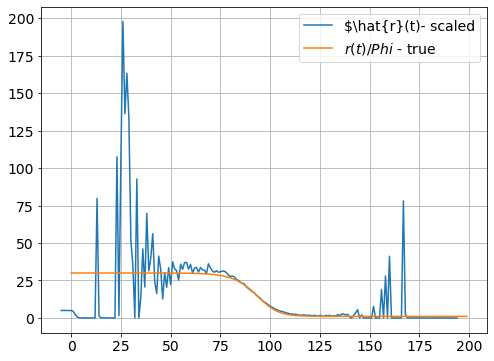

In [30]:
rs = npa([xi[0] for xi in xs])
plt.figure(figsize = (8, 6))
plt.plot(ts - TI,   TR * rs , label = r'$\hat{r}(t)- scaled');
plt.plot(ts,  kfactor * R0 * S/N , label = r'$r(t)/Phi$ - true');
plt.grid(); plt.legend(); #plt.ylim((0., 5.));

### check the use of normalized proxy distributions

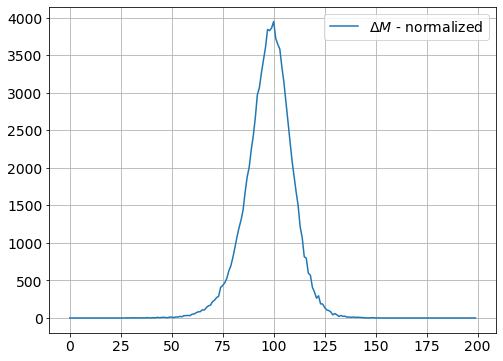

In [31]:
xdios        = np.zeros(len(dios))
i0 = int(TM)
xdios[:-i0]  = dms[i0:]
#norma        = np.sum(xdios)
#xdios        = xdios/norma

#xdios           = dios/2.
plt.figure(figsize = (8, 6))
#plt.plot(ts, dios , label = r'$\Delta I_0$')
plt.plot(ts, xdios, label = r'$\Delta M$ - normalized');
plt.grid(); plt.legend(); #plt.yscale('log');

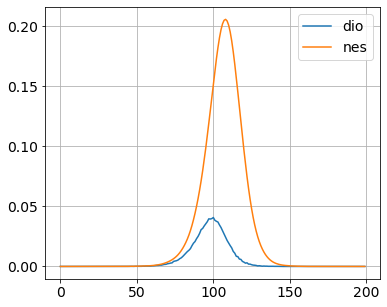

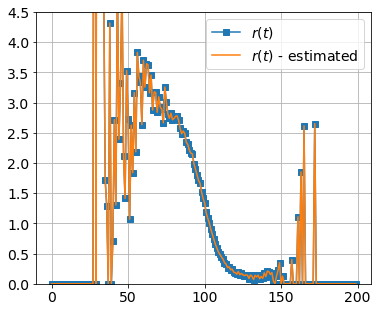

In [36]:
xdios        = np.zeros(len(dios))
i0 = int(TM)
xdios[:-i0]  = dms[i0:]
norma        = np.sum(xdios)
xdios        = xdios/norma

rhoi = frho(TI)
rhor = frho(TR)
rhom = frho(TM)

def myrho(t):
    return (1 - PhiM) * rhor(t) + PhiM * rhom(t)

xnis, xxds = us.ninfecting(ts, xdios, myrho)
xnes       = npa([us.uV(xnis[0:i], ts[0:i], rhoi) for i in range(len(ts))])

xbetas = us.betas(ts, xdios, myrho, rhoi)

ybetas       = np.zeros(len(xdios))
xsel         = xnes > 0
ybetas[xsel] = xdios[xsel]/xnes[xsel]

plt.figure(figsize=(6, 5))
plt.plot(ts, xdios, label = 'dio');
plt.plot(ts, xnes  , label = 'nes');
plt.grid(); plt.legend(); #plt.yscale('log');
plt.figure(figsize = (6, 5));
plt.plot(ts, ybetas * TR    , marker = 's', label = r'$r(t)$' ); 
plt.plot(ts, xbetas     * TR, label = r'$r(t)$ - estimated');
#plt.plot(TR + ts, (R0/TR) * S/N, label = r'$r(t)$ true ');
plt.grid(); plt.legend(); plt.ylim((0., 1.5*R0)); #plt.yscale('log');

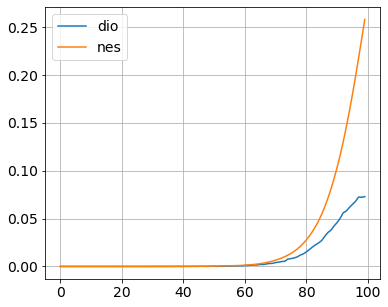

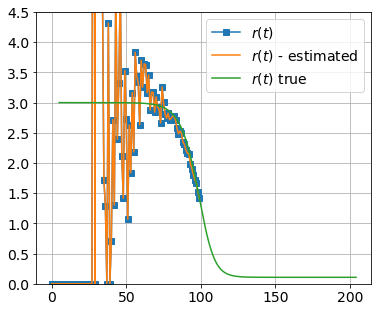

In [38]:
xdios        = np.zeros(len(dios))
i0 = int(TM)
tm = int(22*TI) # len(ts)+1 #int(20*TM)
xdios        = dms[i0:tm]
xts          = np.arange(len(xdios))
norma        = np.sum(xdios)
xdios        = xdios/norma

rhoi = frho(TI)
rhor = frho(TR)
rhom = frho(TM)

def myrho(t):
    return (1 - PhiM) * rhor(t) + PhiM * rhom(t)

xnis, xxds = us.ninfecting(xts, xdios, myrho)
xnes       = npa([us.uV(xnis[0:i], xts[0:i], rhoi) for i in range(len(xts))])

xbetas = us.betas(xts, xdios, myrho, rhoi)

ybetas       = np.zeros(len(xdios))
xsel         = xnes > 0
ybetas[xsel] = xdios[xsel]/xnes[xsel]

plt.figure(figsize=(6, 5))
plt.plot(xts, xdios, label = 'dio');
plt.plot(xts, xnes  , label = 'nes');
plt.grid(); plt.legend(); #plt.yscale('log');
plt.figure(figsize = (6, 5));
plt.plot(xts, ybetas * TR, marker = 's', label = r'$r(t)$' ); 
plt.plot(xts, xbetas * TR, label = r'$r(t)$ - estimated');
plt.plot(TR + ts, R0 * S/N, label = r'$r(t)$ true ');
plt.grid(); plt.legend(); plt.ylim((0., 1.5*R0)); #plt.yscale('log');

## Pandemic with R quenching. 

In [46]:
# Normal Pandemic evolution

N               = 1e6
R0, TI, TR, TM  = 3., 5., 5., 7.
PhiM            = 0.01
ndays           = 200
rho             = 'gamma'
frho            = us.frho(rho)

s1, r1          = 0.15, R0
SS, DD          = us.uSEIR_Rvar(N, R0, TI, TR, TM, PhiM, s1, r1, ndays, rho)
S, E, I, R, M   = SS
DE, DI0, DR, DM = DD

fgamma


fgamma


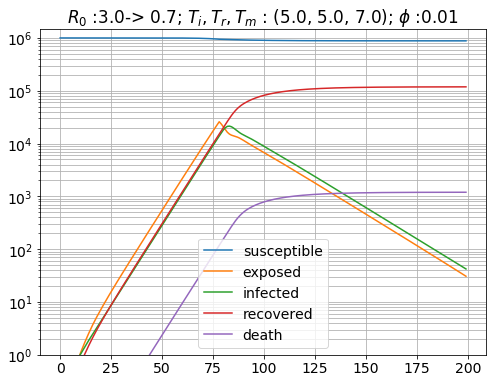

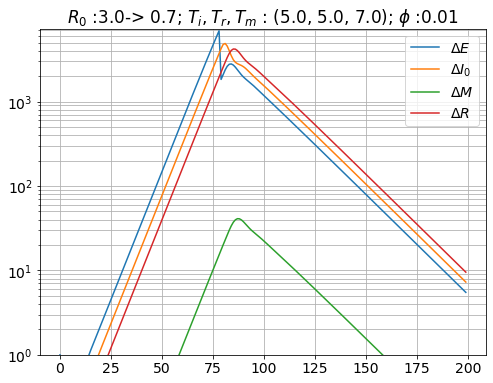

In [50]:
# quenched Pandemic evolution

s1, r1          = 0.05, 0.70 # fraction of the sucecptible afected and R of the quenchinb
SS1, DD1        = us.uSEIR_Rvar(N, R0, TI, TR, TM, PhiM, s1, r1, ndays, rho)
S1, E1, I1, R1, M1  = SS1
DE1, DI01, DR1, DM1 = DD1

ts = np.arange(ndays)
title = r'$R_0$ :'+ str(R0)+ '-> '+str(r1)+ r'; $T_i, T_r, T_m$ : '+str((TI, TR, TM)) + r'; $\phi$ :'+str(PhiM)
us.plt_uSEIR(ts, SS1, DD1, title, yscale = 'log');

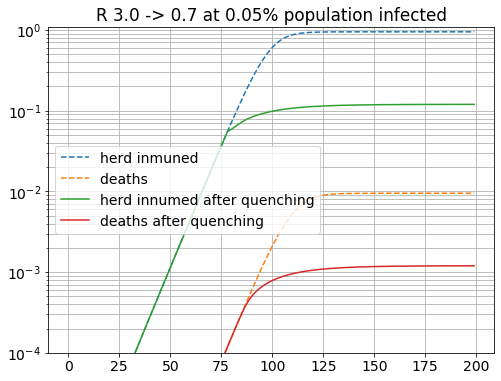

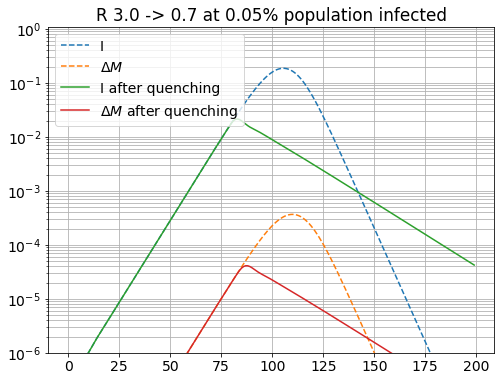

In [51]:
plt.figure(figsize = (8, 6))
plt.plot(ts, 1-S/N , ls = '--', label = 'herd inmuned');
plt.plot(ts, M/N , ls = '--', label = 'deaths ');
plt.plot(ts, 1-S1/N , ls = '-', label = 'herd innumed after quenching');
plt.plot(ts, M1/N, ls = '-', label = 'deaths after quenching');
plt.title('R '+str(R0)+' -> '+str(r1)+' at '+str(s1)+ "% population infected");
plt.grid(which = 'both'); plt.legend(); plt.yscale('log'); plt.ylim((1e-4, 1.1));

plt.figure(figsize = (8, 6))
plt.plot(ts, I/N  , ls = '--', label = 'I');
plt.plot(ts, DM/N , ls = '--', label = r'$\Delta M$');
plt.plot(ts, I1/N , ls = '-', label = 'I after quenching');
plt.plot(ts, DM1/N, ls = '-', label = r'$\Delta M$ after quenching');
plt.title('R '+str(R0)+' -> '+str(r1)+' at '+str(s1)+ "% population infected");
plt.grid(which = 'both'); plt.legend(); plt.yscale('log'); plt.ylim((1e-6, 1.1));

In [52]:
print('Deaths in a million ', M1[-1], 'in Spain', 45e6 * M1[-1]/N)

Deaths in a million  1197.0020789356688 in Spain 53865.09355210509


### check that r(t) follows the quenching

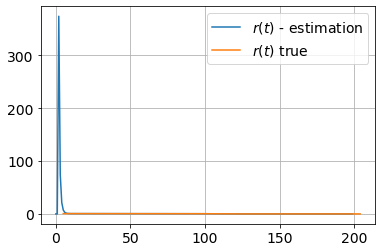

In [43]:
rhor = frho(TR)
rhom = frho(TM)

def myrho(t):
    return (1 - PhiM) * rhor(t) + PhiM * rhom(t)

xdios = DI01

betas = us.betas(ts, xdios, myrho, rhoi)

tbetas = S1/(N*TR)
sel = 1-S1/N <= s1
tbetas[sel]   = tbetas[sel]  * R0
tbetas[~sel]  = tbetas[~sel] * r1
plt.plot(ts, betas, label  = r'$r(t)$ - estimation');
plt.plot(TI + ts, tbetas, label = r'$r(t)$ true');
plt.grid(); plt.legend();

### Check what happens if detector is longer than infection

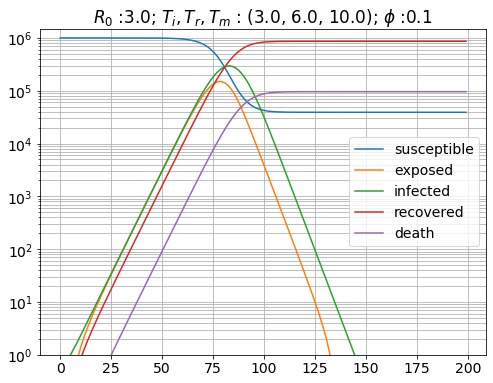

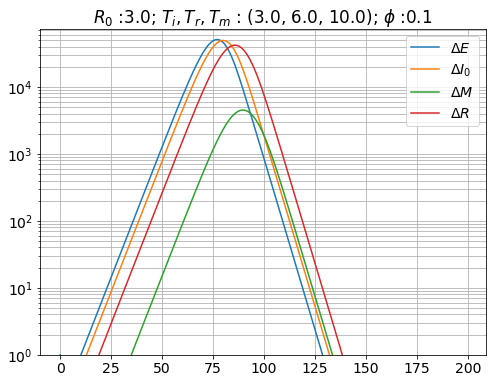

In [44]:
N               = 1e6
R0, TI, TR, TM  = 3., 3., 6., 10.
PhiM            = 0.1
ndays           = 200
rho             = 'poisson'
frho            = us.frho(rho)
ts = np.arange(ndays)
SS, DD          = us.uSEIR(N, R0, TI, TR, TM, PhiM, ndays, rho = rho)
S, E, I, R, M   = SS
DE, DI0, DR, DM = DD

title = r'$R_0$ :'+ str(R0)+ r'; $T_i, T_r, T_m$ : '+str((TI, TR, TM)) + r'; $\phi$ :'+str(PhiM)
us.plt_uSEIR(ts, SS, DD, title)

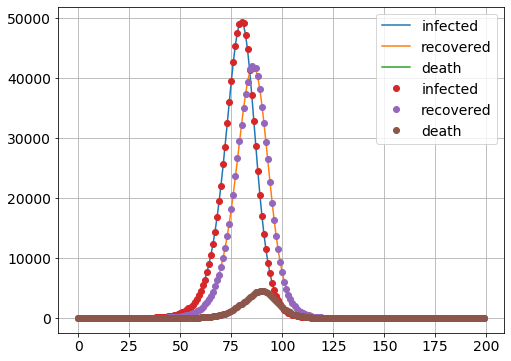

In [45]:
ds = us.useir_rvdata(DI0, DR, DM)
dios, drs, dms = ds
us.plt_useir_rvdata(ts, (DI0, DR, DM), ds);

In [ ]:
rhoi = frho(TI)
rhor = frho(TR)
rhom = frho(TM)

def myrho(t):
    return (1 - PhiM) * rhor(t) + PhiM * rhom(t)

xdios = dios

xbetas = us.betas(ts, xdios, myrho, rhoi)

plt.plot(ts, TR * xbetas, label  = r'$\hat{r}(t)$ - estimation');
plt.plot(TI + ts, R0 * S/N, label = r'$r(t)$ true');
plt.grid(); plt.legend();

### check proxy

In [ ]:
xdios        = np.zeros(len(dios))
i0 = int(TM)
xdios[:-i0]  = dms[i0:]/(PhiM)
#xdios           = dios/2.
plt.figure(figsize = (8, 6))
plt.plot(ts, dios , label = r'$\Delta I_0$')
plt.plot(ts, xdios, label = r'$\Delta M/\Phi$ - $\Phi$-scaled');
plt.grid(); plt.legend(); #plt.yscale('log');

In [ ]:
rhoi = frho(TI)
rhor = frho(TR)
rhom = frho(TM)

def myrho(t):
    return (1 - PhiM) * rhor(t) + PhiM * rhom(t)

xbetas = us.betas(ts, xdios, myrho, rhoi)

plt.plot(ts, TR * xbetas, label  = r'$\hat{r}(t)$ - estimation');
plt.plot(TI + ts, R0 * S/N, label = r'$r(t)$ true');
plt.grid(); plt.legend(); plt.ylim(0, 1.5 * R0)

## Evolution of Pandemic

In [ ]:
# Normal pandemic
N               = 1e6
R0, TI, TR, TM  = 3., 5., 5., 7.
PhiM            = 0.01
ndays           = 200
rho             = 'poisson'
frho            = us.frho(rho)

SS, DD          = us.uSEIR(N, R0, TI, TR, TM, PhiM, ndays, rho)
S, E, I, R, M   = SS
DE, DI0, DR, DM = DD

ts = np.arange(ndays)

In [ ]:
# change parameters at t0
t0              = 80
R01             = 0.85

SS0                  = S[t0], DE[t0], DI0[t0]
DD0                  = R[t0], M[t0] , I  [t0]
SS1, DD1             = us.uSEIR(N, R01, TI, TR, TM, PhiM, ndays, rho, SS0, DD0)
S1, E1, I1, R1, M1   = SS1
DE1, DI01, DR1, DM1  = DD1

xts = np.arange(len(S1))
title = r'$R_0$ :'+ str(R01) + r'; $T_i, T_r, T_m$ : '+str((TI, TR, TM)) + r'; $\phi$ :'+str(PhiM)
us.plt_uSEIR(xts + t0, SS1, DD1, title, yscale = 'log')

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(ts, 1-S/N , ls = '--', label = 'herd inmuned');
plt.plot(ts, M/N , ls = '--', label = 'deaths ');
plt.plot(t0 + xts, 1-S1/N , ls = '-', label = 'herd innumed after quenching');
plt.plot(t0 + xts, M1/N, ls = '-', label = 'deaths after quenching');
plt.title('R '+str(R0)+' -> '+str(r1)+' at '+str(s1)+ "% population infected");
plt.grid(which = 'both'); plt.legend(); plt.yscale('log'); plt.ylim((1e-4, 1.1));

plt.figure(figsize = (8, 6))
plt.plot(ts, I/N  , ls = '--', label = 'I');
plt.plot(ts, DM/N , ls = '--', label = r'$\Delta M$');
plt.plot(t0 + xts, I1/N , ls = '-', label = 'I after quenching');
plt.plot(t0 + xts, DM1/N, ls = '-', label = r'$\Delta M$ after quenching');
plt.title('R '+str(R0)+' -> '+str(r1)+' at '+str(s1)+ "% population infected");
plt.grid(which = 'both'); plt.legend(); plt.yscale('log'); plt.ylim((1e-6, 1.1));

In [ ]:
print('Deaths in a million ', M1[-1], 'in Spain', 45e6 * M1[-1]/N)